In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.sql.functions import col
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
# Initialize PySpark session
spark = SparkSession.builder.appName("StockPricePrediction").getOrCreate()
print("Spark Environment for distributed computing created successfully")

Spark Environment for distributed computing created successfully


In [ ]:
# Define the time range
start = '2010-01-01'
end = '2019-12-31'

# Fetch data using yfinance and convert to Spark DataFrame
import yfinance as yf
df_pandas = yf.download('AAPL', start, end).reset_index()
spark_df = spark.createDataFrame(df_pandas)
spark_df.head(10)

# Fetch data using yfinance
df = yf.download('AAPL', start, end)

# Display the first few rows
print(df.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price                     Adj Close     Close      High       Low      Open  \
Ticker                         AAPL      AAPL      AAPL      AAPL      AAPL   
Date                                                                          
2010-01-04 00:00:00+00:00  6.447414  7.643214  7.660714  7.585000  7.622500   
2010-01-05 00:00:00+00:00  6.458560  7.656429  7.699643  7.616071  7.664286   
2010-01-06 00:00:00+00:00  6.355827  7.534643  7.686786  7.526786  7.656429   
2010-01-07 00:00:00+00:00  6.344076  7.520714  7.571429  7.466071  7.562500   
2010-01-08 00:00:00+00:00  6.386254  7.570714  7.571429  7.466429  7.510714   

Price                         Volume  
Ticker                          AAPL  
Date                                  
2010-01-04 00:00:00+00:00  493729600  
2010-01-05 00:00:00+00:00  601904800  
2010-01-06 00:00:00+00:00  552160000  
2010-01-07 00:00:00+00:00  477131200  
2010-01-08 00:00:00+00:00  447610800  


In [ ]:


spark_df
pd.DataFrame(spark_df.head(50))

[*********************100%***********************]  1 of 1 completed


,0,1,2,3,4,5,6
0,2015-01-02,24.347176,27.332500,27.860001,26.837500,27.847500,212818400
1,2015-01-05,23.661276,26.562500,27.162500,26.352501,27.072500,257142000
2,2015-01-06,23.663507,26.565001,26.857500,26.157499,26.635000,263188400
3,2015-01-07,23.995316,26.937500,27.049999,26.674999,26.799999,160423600
4,2015-01-08,24.917269,27.972500,28.037500,27.174999,27.307501,237458000
5,2015-01-09,24.943991,28.002501,28.312500,27.552500,28.167500,214798000
6,2015-01-12,24.329365,27.312500,28.157499,27.200001,28.150000,198603200
7,2015-01-13,24.545370,27.555000,28.200001,27.227501,27.857500,268367600
8,2015-01-14,24.451839,27.450001,27.622499,27.125000,27.260000,195826400
9,2015-01-15,23.788214,26.705000,27.514999,26.665001,27.500000,240056000


from matplotlib import pyplot as plt
_df_0[1].plot(kind='hist', bins=20, title=1)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1[2].plot(kind='hist', bins=20, title=2)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2[3].plot(kind='hist', bins=20, title=3)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3[4].plot(kind='hist', bins=20, title=4)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x=1, y=2, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x=2, y=3, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x=3, y=4, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x=4, y=5, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series[0]
  ys = series[1]
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values(0, ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel(0)
_ = plt.ylabel(1)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series[0]
  ys = series[2]
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values(0, ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel(0)
_ = plt.ylabel(2)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series[0]
  ys = series[3]
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values(0, ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel(0)
_ = plt.ylabel(3)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series[0]
  ys = series[4]
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values(0, ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel(0)
_ = plt.ylabel(4)

from matplotlib import pyplot as plt
_df_12[1].plot(kind='line', figsize=(8, 4), title=1)
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13[2].plot(kind='line', figsize=(8, 4), title=2)
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14[3].plot(kind='line', figsize=(8, 4), title=3)
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15[4].plot(kind='line', figsize=(8, 4), title=4)
plt.gca().spines[['top', 'right']].set_visible(False)

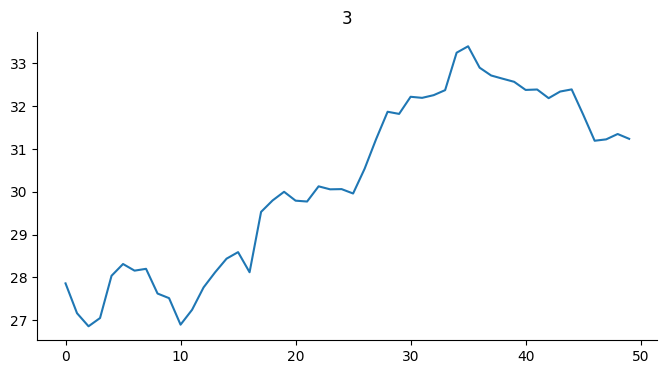

In [ ]:
from matplotlib import pyplot as plt
_df_14[3].plot(kind='line', figsize=(8, 4), title=3)
plt.gca().spines[['top', 'right']].set_visible(False)

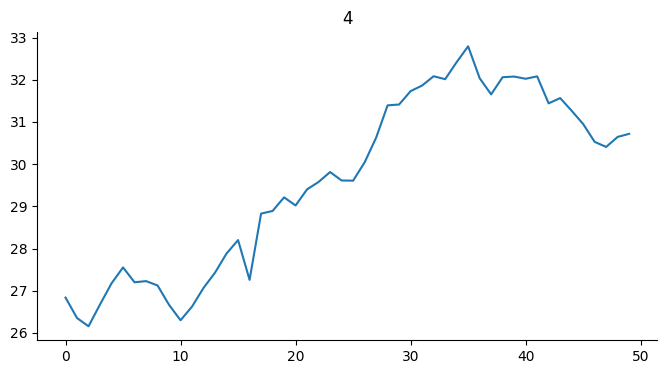

In [ ]:
from matplotlib import pyplot as plt
_df_15[4].plot(kind='line', figsize=(8, 4), title=4)
plt.gca().spines[['top', 'right']].set_visible(False)

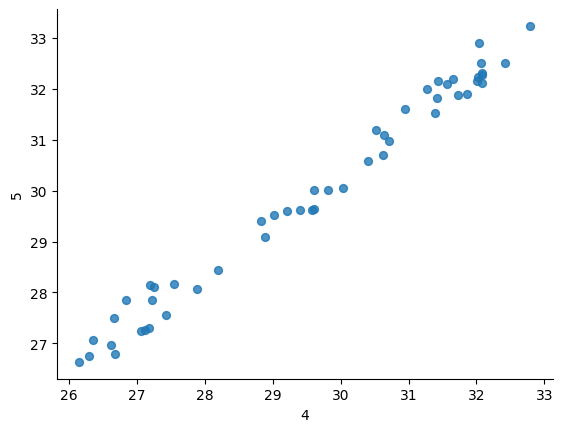

In [ ]:
from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x=4, y=5, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

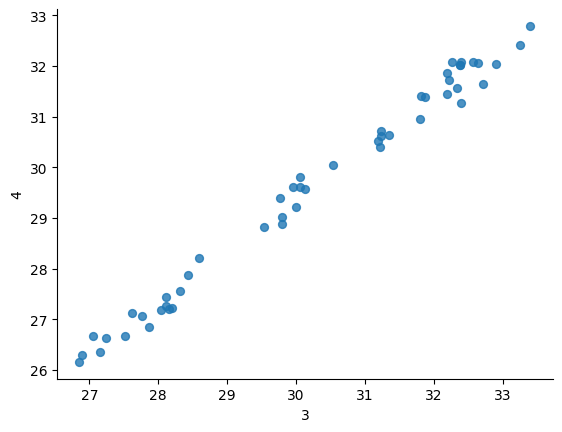

In [ ]:
from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x=3, y=4, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

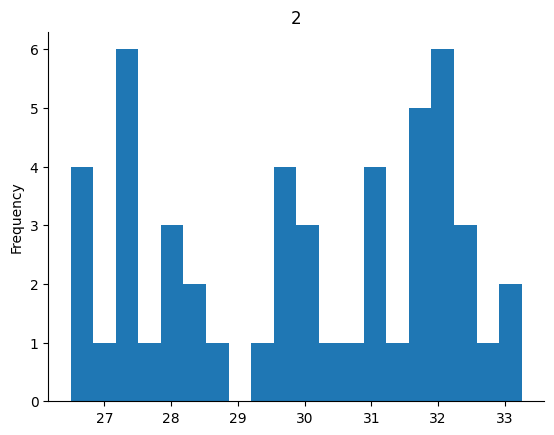

In [ ]:
from matplotlib import pyplot as plt
_df_1[2].plot(kind='hist', bins=20, title=2)
plt.gca().spines[['top', 'right',]].set_visible(False)

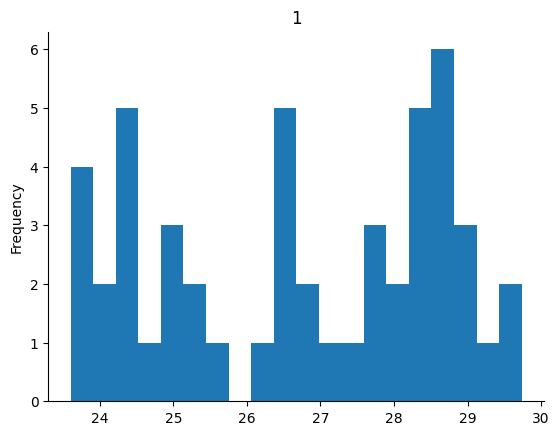

In [ ]:
from matplotlib import pyplot as plt
_df_0[1].plot(kind='hist', bins=20, title=1)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Check column names
print(spark_df.columns)

# Rename columns
spark_df = spark_df.select(
    col("('Date', '')").alias("Date"),
    col("('Adj Close', 'AAPL')").alias("Adj_Close")
)

# Drop missing values
spark_df = spark_df.dropna()

# Display the DataFrame
spark_df.show()


["('Date', '')", "('Adj Close', 'AAPL')", "('Close', 'AAPL')", "('High', 'AAPL')", "('Low', 'AAPL')", "('Open', 'AAPL')", "('Volume', 'AAPL')"]
+-------------------+------------------+
|               Date|         Adj_Close|
+-------------------+------------------+
|2010-01-04 00:00:00| 6.447413921356201|
|2010-01-05 00:00:00| 6.458559989929199|
|2010-01-06 00:00:00|6.3558268547058105|
|2010-01-07 00:00:00| 6.344076156616211|
|2010-01-08 00:00:00| 6.386253833770752|
|2010-01-11 00:00:00| 6.329919338226318|
|2010-01-12 00:00:00| 6.257915496826172|
|2010-01-13 00:00:00| 6.346185207366943|
|2010-01-14 00:00:00| 6.309431552886963|
|2010-01-15 00:00:00| 6.203988552093506|
|2010-01-19 00:00:00| 6.478440761566162|
|2010-01-20 00:00:00|  6.37872314453125|
|2010-01-21 00:00:00| 6.268458366394043|
|2010-01-22 00:00:00|   5.9575514793396|
|2010-01-25 00:00:00| 6.117826461791992|
|2010-01-26 00:00:00| 6.204288959503174|
|2010-01-27 00:00:00| 6.262736797332764|
|2010-01-28 00:00:00| 6.003945827484

In [ ]:
from pyspark.ml.linalg import Vectors

# Verify the column names
print(spark_df.columns)

# Assuming the correct column name is verified, use it in your transformation
vector_df = spark_df.rdd.map(lambda row: (row.Date, Vectors.dense(row.Adj_Close))).toDF(["Date", "features"])



['Date', 'Adj_Close']


In [ ]:
# Apply MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(vector_df)
scaled_df = scaler_model.transform(vector_df)

In [ ]:
# Collect scaled data for training and testing
scaled_data = scaled_df.select("scaled_features").rdd.flatMap(lambda x: x.scaled_features).collect()


In [ ]:
# Convert scaled data to NumPy array
scaled_data = np.array(scaled_data).reshape(-1, 1)

In [ ]:
# Prepare training and testing datasets
data_training = scaled_data[:int(len(scaled_data) * 0.70)]
data_testing = scaled_data[int(len(scaled_data) * 0.70):]

In [ ]:
# Prepare training data for LSTM
x_train, y_train = [], []
for i in range(100, len(data_training)):
    x_train.append(data_training[i-100:i])
    y_train.append(data_training[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)


In [ ]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
# Build LSTM Model
model = Sequential()

# LSTM layers with Dropout
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=50)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - loss: 0.0157
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0018
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0016
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0013
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0012
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0011
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0011
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0011
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0013
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 8.7906e-04
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 8.7780e-04
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 7.6846e-04
Epoch 13/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 7.1925e-04
Epoch 14/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 7.4879e-04
Epoch 15/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/st

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 60)             │          26,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 60)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 80)             │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 120)                 │          96,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 536,285 (2.05 MB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 357,524 (1.36 MB)

In [ ]:
# Prepare testing data
past_100_days = data_training[-100:]
final_testing_data = np.concatenate((past_100_days, data_testing), axis=0)


In [ ]:
x_test, y_test = [], []
for i in range(100, len(final_testing_data)):
    x_test.append(final_testing_data[i-100:i])
    y_test.append(final_testing_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(755, 100, 1)
(755,)


In [ ]:
# Predict using the trained model
y_predicted = model.predict(x_test)
print(y_predicted)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[0.31556362]
 [0.316413  ]
 [0.31694052]
 [0.31716204]
 [0.31711423]
 [0.3168756 ]
 [0.31658366]
 [0.3163994 ]
 [0.31643605]
 [0.31676847]
 [0.31738186]
 [0.31819975]
 [0.31916785]
 [0.32022548]
 [0.3212999 ]
 [0.32233256]
 [0.32327998]
 [0.32410634]
 [0.32487023]
 [0.3256302 ]
 [0.32641637]
 [0.32721457]
 [0.32797945]
 [0.32898015]
 [0.33043247]
 [0.3324334 ]
 [0.33499146]
 [0.33805388]
 [0.34149677]
 [0.3451735 ]
 [0.34888548]
 [0.35248345]
 [0.3559131 ]
 [0.35914415]
 [0.3621233 ]
 [0.36480236]
 [0.3671779 ]
 [0.36926597]
 [0.3710487 ]
 [0.37251174]
 [0.37366295]
 [0.37452477]
 [0.37525085]
 [0.37593514]
 [0.37665707]
 [0.37743002]
 [0.37823838]
 [0.3790251 ]
 [0.37971836]
 [0.38028514]
 [0.3807174 ]
 [0.3810126 ]
 [0.38124353]
 [0.38148713]
 [0.38176048]
 [0.38211933]
 [0.38252276]
 [0.38298243]
 [0.38348114]
 [0.38397825]
 [0.38444418]
 [0.3849861 ]
 [0.38570255]
 [0.3866224 ]
 [0.387703  ]
 [0.38886857]
 [0.39008135]
 [0.3912663 ]
 [0.3923

In [ ]:
# Scale back to original range
scale_factor = 1 / scaler_model.originalMin
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor
print(y_predicted)
print(y_test)

[[0.05454076]
 [0.05468757]
 [0.05477874]
 [0.05481703]
 [0.05480877]
 [0.05476752]
 [0.05471706]
 [0.05468522]
 [0.05469155]
 [0.05474901]
 [0.05485502]
 [0.05499638]
 [0.05516371]
 [0.0553465 ]
 [0.0555322 ]
 [0.05571068]
 [0.05587443]
 [0.05601725]
 [0.05614928]
 [0.05628063]
 [0.05641651]
 [0.05655447]
 [0.05668667]
 [0.05685962]
 [0.05711064]
 [0.05745647]
 [0.05789859]
 [0.05842789]
 [0.05902295]
 [0.05965842]
 [0.06029998]
 [0.06092184]
 [0.06151461]
 [0.06207305]
 [0.06258796]
 [0.06305099]
 [0.06346157]
 [0.06382247]
 [0.06413058]
 [0.06438345]
 [0.06458242]
 [0.06473138]
 [0.06485687]
 [0.06497514]
 [0.06509991]
 [0.06523351]
 [0.06537322]
 [0.0655092 ]
 [0.06562902]
 [0.06572698]
 [0.06580169]
 [0.0658527 ]
 [0.06589262]
 [0.06593472]
 [0.06598197]
 [0.06604399]
 [0.06611372]
 [0.06619317]
 [0.06627936]
 [0.06636528]
 [0.06644581]
 [0.06653947]
 [0.0666633 ]
 [0.06682228]
 [0.06700905]
 [0.0672105 ]
 [0.06742011]
 [0.06762491]
 [0.06780946]
 [0.06795941]
 [0.068065  ]
 [0.06

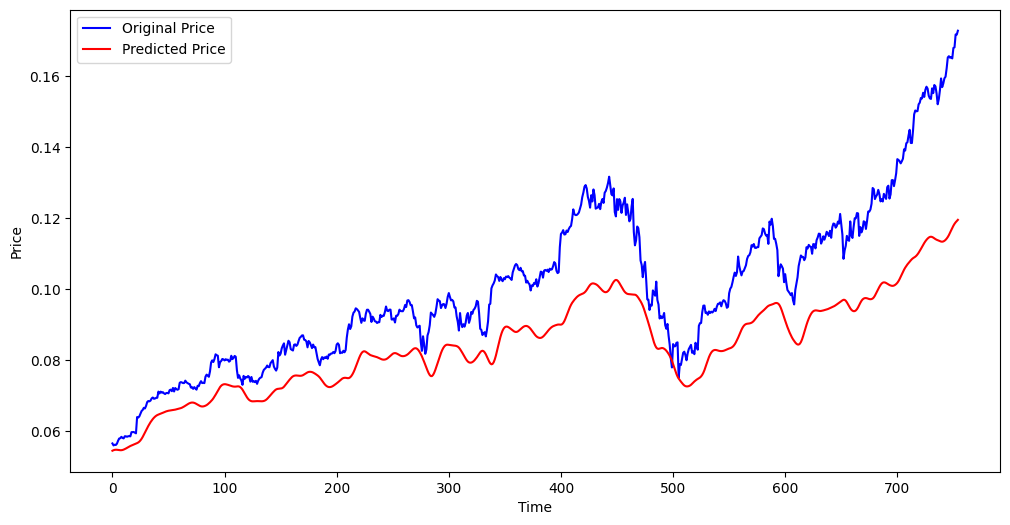

In [ ]:
# Plot the predictions vs original prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'b', label='Original Price')
plt.plot(y_predicted, 'r', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
model.save('keras_model.h5')